In [15]:
import sys

def gmlToPolygon(gmlStr):
    footprint1 = ogr.CreateGeometryFromGML(gmlStr)
    coords = []
    if footprint1.GetGeometryCount()==1:
        g0 = footprint1.GetGeometryRef(0)
        for i in range(0, g0.GetPointCount()):
            pt = g0.GetPoint(i)
            coords.append((pt[1], pt[0]))
    return Polygon(coords)

def downloadFile(url, filepath, user, password):
    if not os.path.exists(os.path.dirname(filepath)):
        os.makedirs(os.path.dirname(filepath))
        
    with open(filepath, "wb") as f:
        print("Downloading %s to %s" % (url, filepath))
        response = requests.get(url, auth=(user, password), stream=True)
        if response.status_code!=200:
            raise Exception("Could not download file. status=%s" % response.status_code)
        total_length = response.headers.get('content-length')

        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                done = int(50 * dl / total_length)
                sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                sys.stdout.flush()

def saveFile(filename, contents):
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    with open(filename, 'w') as fw:
        fw.write(contents)
        fw.flush()

def loadFile(filename):
    with open(filename, 'r') as fr:
        return fr.read()

def convertWGS84To3857(x, y):
    s1 = !echo "{x} {y}" | cs2cs +init=epsg:4326 +to +init=epsg:3857
    s = s1[0].replace(" 0.00", "").split('\t')
    return (float(s[0]), float(s[1]))

def convertGeoJSONFromWGS84To3857(geojson):
    coords = []
    c = geojson['coordinates'][0]
    for co in list(c):
        coords.append(convertWGS84To3857(co[0],co[1]))
    geo = {
        'coordinates': ((tuple(coords)),),
        'type': geojson['type']
    }
    return geo


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
INFO:sentinelloader:Getting contents. band=TCI, resolution=60m, date=2019-01-01
INFO:sentinelloader:Querying API for candidate tiles
DEBUG:sentinelloader:Using cached API query contents
DEBUG:sentinelloader:Found 6 products
DEBUG:sentinelloader:Tiles selected for covering the entire desired area: [1]
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:sentinelloader:Reusing cached metadata info for tile '3e203cc7-7859-4860-8d4b-bca39e28d053'
DEBUG:sentinelloader:Reusing tile data from cache
DEBUG:sentinelloader:Cropping polygon [(-47.873796, -16.044801), (-47.933796, -16.044801), (-47.933796, -15.924801), (-47.873796, -15.924801)] from 1 files
DEBUG:sentinelloader:Combining tiles into a single image. tmpfile=/notebooks/data/output/sentinelcache/tmp/f31bbda4f3944a48982a5dc98617a426.tiff


Creating output file that is 107P x 222L.
Processing input file /notebooks/data/output/sentinelcache/products/2019-01-20/3e203cc7-7859-4860-8d4b-bca39e28d053/T22LHH_20190120T132239_TCI_60m.tiff.
Copying nodata values from source /notebooks/data/output/sentinelcache/products/2019-01-20/3e203cc7-7859-4860-8d4b-bca39e28d053/T22LHH_20190120T132239_TCI_60m.tiff to destination /notebooks/data/output/sentinelcache/tmp/f31bbda4f3944a48982a5dc98617a426.tiff.
0...10...20...30...40...50...60...70...80...90...100 - done.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


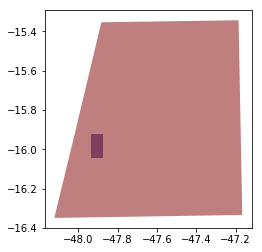

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


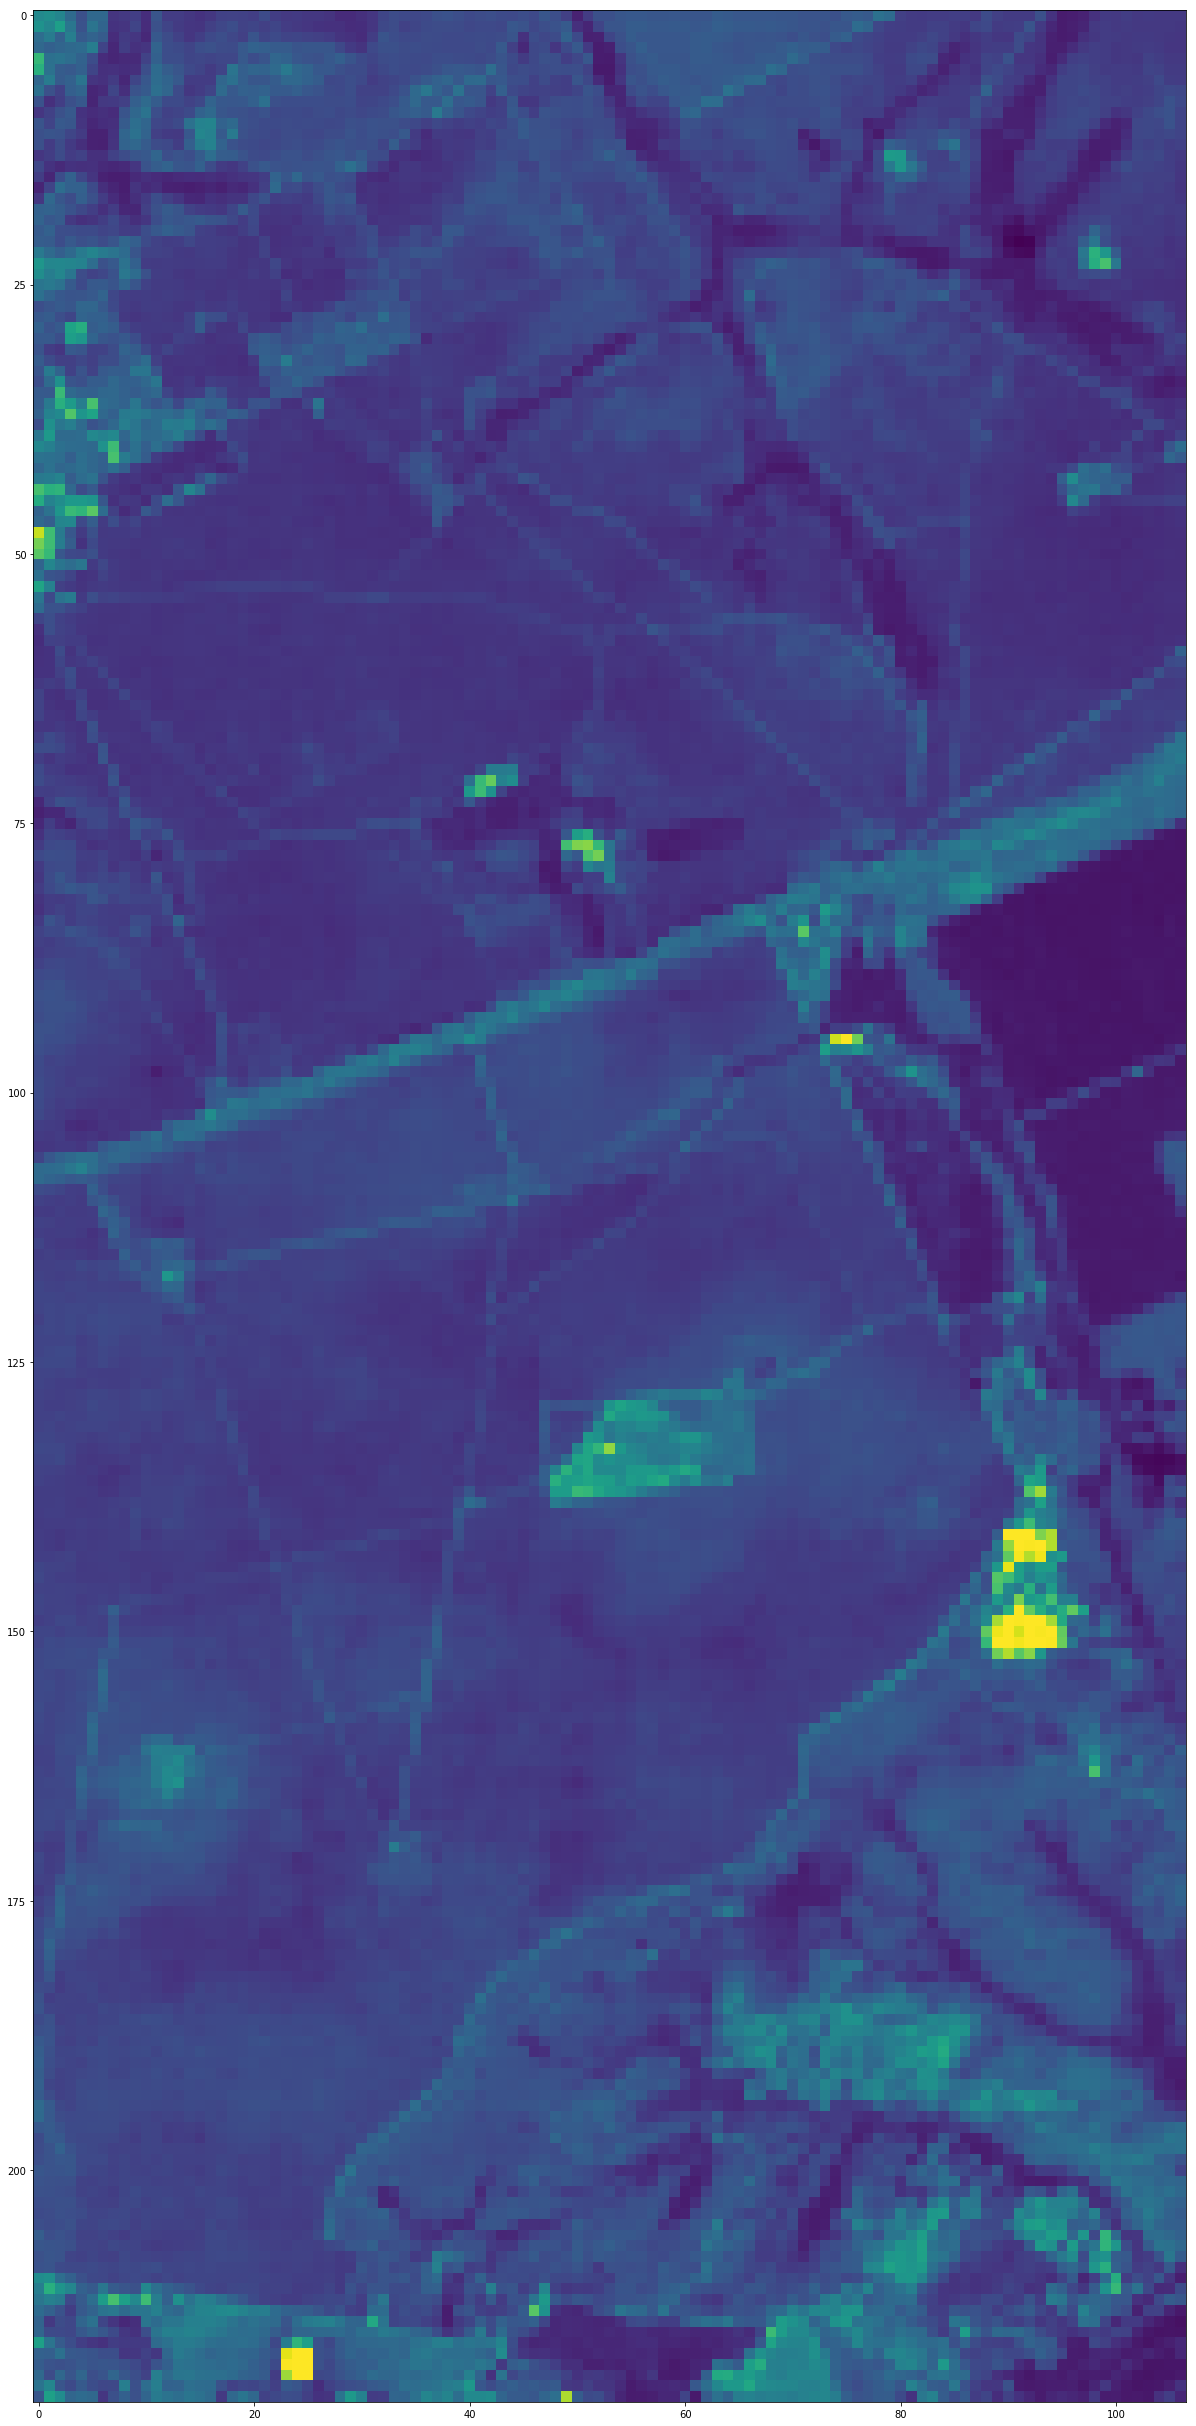

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from sentinelsat import SentinelAPI
import datetime
from datetime import timedelta
from shapely.geometry import Point, Polygon, mapping
from shapely.affinity import scale
import logging
import utils
from osgeo import ogr
from shapely.wkt import loads
import geopandas as gpd
import pandas as pd
import descartes
import requests
import os
import re
import os.path
from osgeo import gdal
import hashlib
from PIL import Image
import uuid
import fiona
import numpy as np

logger = logging.getLogger('sentinelloader')
logging.basicConfig(level=logging.DEBUG)

BORDER_SHRINK = 1/0.95

class SentinelLoader:

    def __init__(self, dataPath, user, password, apiUrl='https://scihub.copernicus.eu/apihub/', showProgressbars=True):
        self.api = SentinelAPI(user, password, apiUrl, show_progressbars=showProgressbars)
        self.dataPath = dataPath
        self.user = user
        self.password = password
    
    def getProductBandTiles(self, geoPolygon, bandName, resolution, dateReference='now', dateToleranceDays=5, cloudCoverage=(0,80), cacheApiCalls=True, cacheTilesData=True):
        """Downloads and returns file names with Sentinel2 tiles that best fit the polygon area at the desired date reference"""
        logger.info("Getting contents. band=%s, resolution=%s, date=%s", bandName, resolution, dateReference)

        #find tiles that intercepts geoPolygon within date-tolerance and date+dateTolerance
        dateTolerance = timedelta(days=dateToleranceDays)
        dateObj = datetime.datetime.now()
        if dateReference != 'now':
            dateObj = datetime.datetime.strptime(dateReference, '%Y-%m-%d')

        dateFrom = dateObj-dateTolerance
        dateTo = dateObj+dateTolerance

        logger.info("Querying API for candidate tiles")
        area = Polygon(geoPolygon).wkt
        
        #query cache key
        area_hash = hashlib.md5(area.encode()).hexdigest()
        apicache_file = self.dataPath + "/apiquery/Sentinel-2-S2MSI2A-%s-%s-%s-%s-%s.csv" % (area_hash, dateFrom.strftime("%Y%m%d"), dateTo.strftime("%Y%m%d"), cloudCoverage[0], cloudCoverage[1])
        products_df = None
        if cacheApiCalls:            
            if os.path.isfile(apicache_file):
                logger.debug("Using cached API query contents")
                products_df = pd.read_csv(apicache_file)
                !touch -c {apicache_file}
            else:
                logger.debug("Querying remote API")
                products = self.api.query(area, 
                                               date=(dateFrom.strftime("%Y%m%d"), dateTo.strftime("%Y%m%d")),
                                               platformname='Sentinel-2', producttype='S2MSI2A', cloudcoverpercentage=cloudCoverage)
                products_df = self.api.to_dataframe(products)
                logger.debug("Caching API query results for later usage")
                saveFile(apicache_file, products_df.to_csv(index=True))

        logger.debug("Found %d products", len(products_df))

        if len(products_df)==0:
            raise Exception('Could not find any tiles for the specified parameters')
        
        products_df_sorted = products_df.sort_values(['ingestiondate','cloudcoverpercentage'], ascending=[False, False])

        #select the best product. if geoPolygon() spans multiple tiles, select the best of them
        missing = Polygon(geoPolygon)
        desiredRegion = Polygon(geoPolygon)
        selectedTiles = []
        footprints = [desiredRegion]

        for index, pf in products_df_sorted.iterrows():
            #osgeo.ogr.Geometry
            footprint = gmlToPolygon(pf['gmlfootprint'])
            
            if missing.area>0:
                if missing.intersects(footprint)==True:
                    missing = (missing.symmetric_difference(footprint)).difference(footprint)
                    selectedTiles.append(index)
                    footprints.append(footprint)                

        if missing.area>0:
            raise Exception('Could not find tiles for the whole selected area at date range')

        logger.debug("Tiles selected for covering the entire desired area: %s", selectedTiles)

        g = gpd.GeoSeries(footprints)
        g.plot(cmap=plt.get_cmap('jet'), alpha=0.5)

        #download tiles data
        tileFiles = []
        for index, sp in products_df.loc[selectedTiles].iterrows():
            url = "https://scihub.copernicus.eu/dhus/odata/v1/Products('%s')/Nodes('%s.SAFE')/Nodes('MTD_MSIL2A.xml')/$value" % (sp['uuid'], sp['title'])

            meta_cache_file = self.dataPath + "/products/%s-MTD_MSIL2A.xml" % (sp['uuid'])
            mcontents = ''
            if cacheTilesData:
                if os.path.isfile(meta_cache_file):
                    logger.debug('Reusing cached metadata info for tile \'%s\'', sp['uuid'])
                    mcontents = loadFile(meta_cache_file)
                    !touch -c {meta_cache_file}
                else:
                    logger.debug('Getting metadata info for tile \'%s\' remotelly', sp['uuid'])
                    r = requests.get(url, auth=(self.user, self.password))
                    mcontents = r.content.decode("utf-8")
                    saveFile(meta_cache_file, mcontents)

            rexp = "<IMAGE_FILE>GRANULE\/([0-9A-Z_]+)\/IMG_DATA\/R%s\/([0-9A-Z_]+_%s_%s)<\/IMAGE_FILE>" % (resolution, bandName, resolution)
            m = re.search(rexp, mcontents)
            if m==None:
                raise Exception("Could not find image metadata. uuid=%s, resolution=%s, band=%s" % (sp['uuid'], resolution, bandName))
                
            rexp1 = "<PRODUCT_START_TIME>([\-0-9]+)T[0-9\:\.]+Z<\/PRODUCT_START_TIME>"
            m1 = re.search(rexp1, mcontents)
            if m1==None:
                raise Exception("Could not find product date from metadata")
                
            filename = self.dataPath + "/products/%s/%s/%s.tiff" % (m1.group(1), sp['uuid'], m.group(2))
            if not os.path.exists(os.path.dirname(filename)):
                os.makedirs(os.path.dirname(filename))

            if not cacheTilesData or not os.path.isfile(filename):
                tmp_tile_filejp2 = "%s/tmp/%s.jp2" % (self.dataPath, uuid.uuid4().hex)
                tmp_tile_filetiff = "%s/tmp/%s.jp2" % (self.dataPath, uuid.uuid4().hex)
                if not os.path.exists(os.path.dirname(tmp_tile_filejp2)):
                    os.makedirs(os.path.dirname(tmp_tile_filejp2))
                url = "https://scihub.copernicus.eu/dhus/odata/v1/Products('%s')/Nodes('%s.SAFE')/Nodes('GRANULE')/Nodes('%s')/Nodes('IMG_DATA')/Nodes('R%s')/Nodes('%s.jp2')/$value" % (sp['uuid'], sp['title'], m.group(1), resolution, m.group(2))
                logger.info('Downloading tile uuid=\'%s\', resolution=\'%s\', band=\'%s\'', sp['uuid'], resolution, bandName)
                downloadFile(url, tmp_tile_filejp2, self.user, self.password)
                #remove near black features on image border due to compression artifacts. if not removed, some black pixels 
                #will be present on final image, specially when there is an inclined crop in source images
                logger.debug('Removing near black compression artifacts')
                !nearblack -o {tmp_tile_filetiff} {tmp_tile_filejp2}
                os.remove(tmp_tile_filejp2)
                !gdal_translate {tmp_tile_filetiff} {filename}
                os.remove(tmp_tile_filetiff)
            else:
                logger.debug('Reusing tile data from cache')

            !touch -c {filename}
            tileFiles.append(filename)

        return tileFiles

    def cropRegion(self, geoPolygon, sourceGeoTiffs):
        """Returns an image file with contents from a bunch of GeoTiff files cropped to the specified geoPolygon.
           Pay attention to the fact that a new file is created at each request and you should delete it after using it"""
        logger.debug("Cropping polygon %s from %d files" % (geoPolygon, len(sourceGeoTiffs)))
        desiredRegion = Polygon(geoPolygon)
        #show tile images
#         for fn in tilesData:
#             ds = gdal.Open(fn).ReadAsArray()
#             plt.figure(figsize=(10,10))
#             plt.imshow(ds[0])

        source_tiles = ' '.join(sourceGeoTiffs)
        tmp_file = "%s/tmp/%s.tiff" % (self.dataPath, uuid.uuid4().hex)
        if not os.path.exists(os.path.dirname(tmp_file)):
            os.makedirs(os.path.dirname(tmp_file))
        
        #define output bounds in destination srs reference
        bounds = desiredRegion.bounds
        s1 = convertWGS84To3857(bounds[0], bounds[1])
        s2 = convertWGS84To3857(bounds[2], bounds[3])

        logger.debug('Combining tiles into a single image. tmpfile=%s' % tmp_file)
        !gdalwarp -multi -srcnodata 0 -t_srs EPSG:3857 -te {s1[0]} {s1[1]} {s2[0]} {s2[1]} {source_tiles} {tmp_file}

#         ds = gdal.Open(tmp_file).ReadAsArray()
#         logger.debug('Removing temp files')
#         os.remove(tmp_file)
        return tmp_file

    def createMosaic(self, geoPolygon, sourceGeoTiffs):

sl = SentinelLoader('/notebooks/data/output/sentinelcache', '', '', apiUrl='https://scihub.copernicus.eu/apihub/', showProgressbars=True)

# area = [(-51.15, -14),(-51.8,-14),(-51.8,-14.25),(-51.15,-14.25),(-51.15,-14)]# area = [(-51.15, -14),(-51.8,-14),(-51.8,-14.25),(-51.15,-14.25),(-51.15,-14)]
area=[(-47.873796,-16.044801),(-47.933796,-16.044801),(-47.933796,-15.924801),(-47.873796,-15.924801)]
# area = [(-51.15, -14),(-52.1,-14),(-52.1,-14.25),(-51.15,-14.25),(-51.15,-14)]# area = [(-51.15, -14),(-51.8,-14),(-51.8,-14.25),(-51.15,-14.25),(-51.15,-14)]
# area = [(-44.8, -15),(-46.2,-15),(-46.2,-15.2),(-44.8,-15.2)]# area = [(-51.15, -14),(-51.8,-14),(-51.8,-14.25),(-51.15,-14.25),(-51.15,-14)]
# area = [(-50.45, -15.25),(-50.65, -15.25),(-50.65, -15.45),(-50.65, -15.45),(-49.5, -16.5)]
# area = [(-44.8, -15),(-45.3,-15),(-45.3,-15.2),(-44.8,-15.2)]# area = [(-51.15, -14),(-51.8,-14),(-51.8,-14.25),(-51.15,-14.25),(-51.15,-14)]
geoTiffs = sl.getProductBandTiles(area, 'TCI', '60m', dateReference='2019-01-01', dateToleranceDays=20, cloudCoverage=(0,40))
geoTiff = sl.cropRegion(area, geoTiffs)
ds = gdal.Open(geoTiff).ReadAsArray()
plt.figure(figsize=(44,44))
plt.imshow(ds[0])
plt.show()
os.remove(geoTiff)
# img = plt.imread(geoTiff)
# plt.imshow(img[:, :, 0], cmap=plt.cm.coolwarm)
# sl.getContents(area, 'TCI', '10m', dateReference='2019-01-01', dateToleranceDays=20, cloudCoverage=(0,40), cloudless=False, cloudlessDays=20)
# area = [(-44.8, -15),(-45.1,-15),(-45.1,-15.2),(-44.8,-15.2)]# area = [(-51.15, -14),(-51.8,-14),(-51.8,-14.25),(-51.15,-14.25),(-51.15,-14)]
# sl.getContents(area, 'TCI', '60m', dateReference='now', dateToleranceDays=20, cloudCoverage=(0,40), cloudless=False, cloudlessDays=20)
